In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk

#datasets = load_dataset("swag", "regular")
datasets = load_from_disk("swag.hf")
if False:
    # the labels for the test split are not public, therefore we create our own split
    # 60% train, 20% validation, 20% test
    merged_datasets = concatenate_datasets([datasets["train"], datasets["validation"]])
    
    train_testvalid = merged_datasets.train_test_split(test_size=0.4)
    # Split the 10% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    datasets = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'validation': test_valid['train']})
else: 
    datasets
#datasets.save_to_disk("swag.hf")

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
batch_size = 16

/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
ending_names = ["ending0", "ending1", "ending2", "ending3"]

def preprocess_function(examples):
    # Repeat each first sentence four times to go with the four possibilities of second sentences.
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["sent2"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]

    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, max_length=256)
    # Un-flatten
    return {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}



In [4]:
encoded_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/56131 [00:00<?, ? examples/s]

Map:   0%|          | 0/18711 [00:00<?, ? examples/s]

Map:   0%|          | 0/18710 [00:00<?, ? examples/s]

In [5]:
from transformers import TrainingArguments, Trainer, AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained("microsoft/deberta-v3-base")

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
args = TrainingArguments(
    "deberta-base-finetuned-swag",
    evaluation_strategy = "steps",
    eval_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)


/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [8]:
accepted_keys = ["input_ids", "attention_mask", "label"]
features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
batch = DataCollatorForMultipleChoice(tokenizer)(features)

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
import numpy as np

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [10]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_3191/3095340611.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
train = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.612100,0.515618,0.810689
2000,0.547200,0.515780,0.810369
3000,0.545400,0.470444,0.825174
4000,0.343800,0.484952,0.827472
5000,0.341000,0.492413,0.827739
6000,0.343400,0.511340,0.832817
7000,0.330000,0.484779,0.833779
8000,0.217600,0.587938,0.837894
9000,0.217800,0.627988,0.836291
10000,0.204000,0.621848,0.836718


In [12]:
evaluated = trainer.evaluate()
evaluated

{'eval_loss': 0.63127601146698,
 'eval_accuracy': 0.8368786573410034,
 'eval_runtime': 79.3358,
 'eval_samples_per_second': 235.833,
 'eval_steps_per_second': 14.747,
 'epoch': 3.0}

In [13]:
import pandas as pd
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
0,0.6921,13.771041,0.000019,500,0.515618,0.810689,79.3844,235.689,14.738,NaN,NaN,NaN,NaN,NaN
1,0.3438,4.823062,0.000012,4000,0.484952,0.827472,79.3052,235.924,14.753,NaN,NaN,NaN,NaN,NaN
2,0.2149,17.124437,0.000006,7500,0.587938,0.837894,79.2997,235.940,14.754,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,10527,0.631276,0.836879,79.3358,235.833,14.747,3220.9325,52.281,3.268,1.843782e+16,0.375836


In [14]:
test_pred = trainer.predict(encoded_datasets["test"])
test_pred.metrics

{'test_loss': 0.637482225894928,
 'test_accuracy': 0.8346427083015442,
 'test_runtime': 79.8596,
 'test_samples_per_second': 234.299,
 'test_steps_per_second': 14.651}

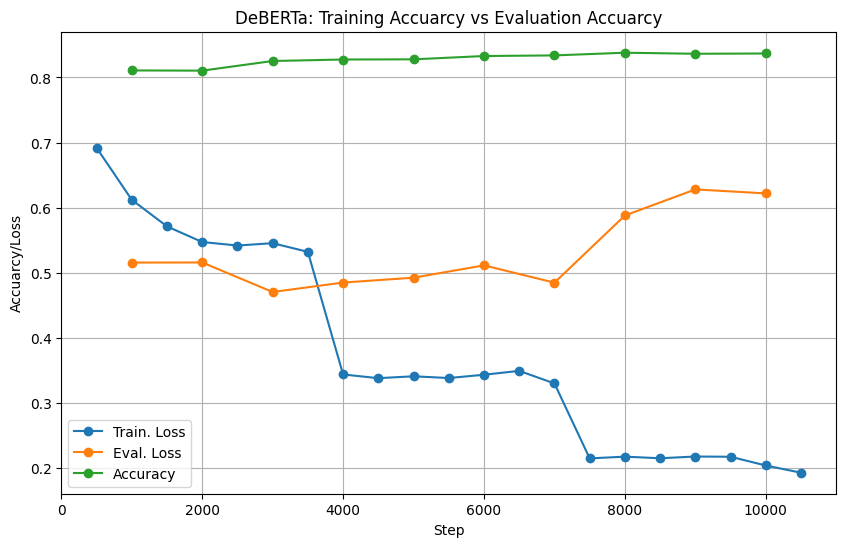

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
data = training_history_bert_base[["loss", "eval_loss", "step", "eval_accuracy"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Accuracy"]
data = data[:-1]  # drop last row
data = pd.melt(data, ['Training Steps']).dropna()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot each variable separately without using groupby
train_loss = data[data['variable'] == "Train. Loss"]
eval_loss = data[data['variable'] == "Eval. Loss"]
acc = data[data['variable'] == "Accuracy"]

plt.plot(train_loss["Training Steps"], train_loss["value"], marker='o', label="Train. Loss")
plt.plot(eval_loss["Training Steps"], eval_loss["value"], marker='o', label="Eval. Loss")
plt.plot(acc["Training Steps"], acc["value"], marker='o', label="Accuracy")

# Labels and Title
plt.ylabel('Accuarcy/Loss')
plt.xlabel('Step')
plt.title('DeBERTa: Training Accuarcy vs Evaluation Accuarcy')
plt.legend()
plt.grid(True)

# Show plot
plt.savefig('deberta_base_swag_finetuned.png')


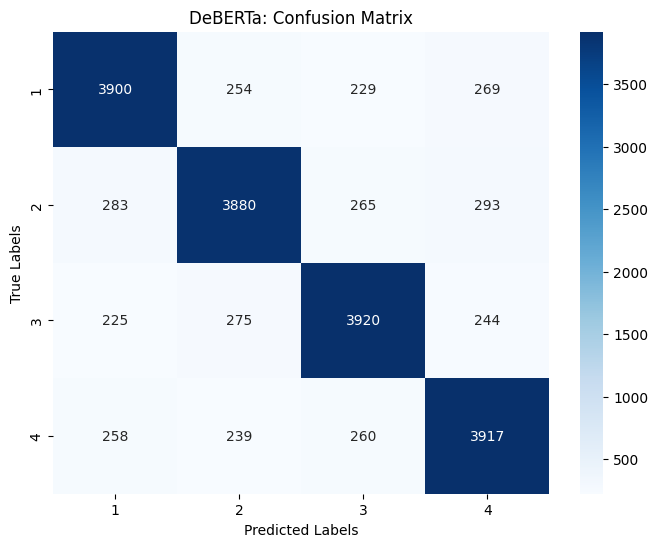

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")

predictions = np.argmax(test_pred.predictions, axis=-1)
metric.add_batch(predictions=predictions, references=datasets["test"]["label"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

# Define class labels manually (adjust as needed)
labels = ["1", "2", "3", "4"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DeBERTa: Confusion Matrix')
plt.savefig('swag_DeBERTa_base_confusion_matrix.png')
